# 🏠 부동산 실거래가 예측 대회 - KKH - EDA
> - 데이터를 분석해보자.
> - kimkihong / helpotcreator@gmail.com / Upstage AI Lab 3기
> - 2024.07.16.화 ~ 2024.07.19.금 19:00

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(fname=r'font/NanumGothic.otf', name='NanumBarunGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'})
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import re
import math

# Model
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from category_encoders import TargetEncoder, OneHotEncoder, MEstimateEncoder, OrdinalEncoder, CatBoostEncoder

import eli5
from eli5.sklearn import PermutationImportance


# 모든 열을 표시하도록 설정
pd.set_option('display.max_columns', None)

In [2]:
train = pd.read_csv('data/kkh_train.csv', encoding='utf-8')
test = pd.read_csv('data/kkh_test.csv', encoding='utf-8')
subway = pd.read_csv('data/subway_feature.csv', encoding='utf-8')
bus = pd.read_csv('data/bus_feature.csv', encoding='utf-8')
loan = pd.read_csv('data/kkh_loan.csv', encoding='utf-8') # 서울시 가계대출규모
# 서울시 가계대출규모 출처:  https://data.seoul.go.kr/dataList/10339/S/2/datasetView.do

## 서울시 가계대출규모 정보를 추가한다.

- 2008년 포함하여 2023년 12월까지 자료이다.
- 따라서, train 데이터에서 계약년월이 200701 ~ 200712 에는 결측치가 발생할 것이다.

In [3]:
loan.sample(2)

,년월,서울시_가계대출
0,200801,163223.8
12,200901,174921.2


In [4]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   년월        192 non-null    int64  
 1   서울시_가계대출  192 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.1 KB


In [5]:
# '계약년월'과 '년월'이 일치하는 경우 '서울시_가계대출' 정보를 train에 병합
train = train.merge(loan, how='left', left_on='계약년월', right_on='년월')
# '년월' 열은 필요 없으므로 삭제
train.drop(columns=['년월'], inplace=True)

In [6]:
test = test.merge(loan, how='left', left_on='계약년월', right_on='년월')
test.drop(columns=['년월'], inplace=True)

In [7]:
train.sample(2)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,단지신청일,target,구,동,좌표X,좌표Y,동+아파트명,1번째_가까운_역_이름,1번째_가까운_역_호선,1번째_가까운_역_거리,5분이하_역_개수,5분초과_10분이하_역_개수,서울시_가계대출
1078284,서울특별시 강남구 수서동,746,746.0,0.0,까치마을,39.600,200703,14,11,1993,광평로19길 10,NaN,,-,-,NaN,024590778,0262470778,NaN,분양,위탁관리,복도식,지역난방,7.0,1403.0,진흥기업,.,1993-09-08 00:00:00.0,83491.0,57555.0,81933.0,1403.0,0.0,0.0,NaN,NaN,NaN,2024-07-11 17:48:14.0,213-80-02528-0,위탁,단일계약,위탁,0.0,552.0,의무,2017-09-15 14:51:35.0,Y,N,2013-03-07 09:46:36.0,33000,강남구,수서동,127.087640,37.484739,수서동 까치마을,일원,3호선,309.955332,1,0,NaN
242402,서울특별시 강동구 암사동,413,413.0,0.0,프라이어팰리스,59.983,202012,31,20,2007,고덕로 130,NaN,,-,-,아파트,0234274569,0234274571,NaN,분양,위탁관리,계단식,개별난방,22.0,1622.0,"현대,대림","현대,대림",2007-07-09 00:00:00.0,263646.0,140765.0,181847.0,328.0,914.0,380.0,NaN,www.priorpalace.net,NaN,2023-09-24 20:26:47.0,916-09-43852-1,위탁,종합계약,위탁,9636.9,2183.0,의무,2018-03-20 14:37:59.0,Y,N,2013-03-07 09:46:18.0,115000,강동구,암사동,127.139523,37.553530,암사동 프라이어팰리스,명일,5호선,461.941878,0,1,363817.0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1118822 entries, 0 to 1118821
Data columns (total 61 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  object 
 1   번지                      1118597 non-null  object 
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  object 
 5   전용면적(㎡)                 1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  object 
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  1118822 non-null  object 
 13  거래유형                    1118822 non-null  object 
 14  중개

In [9]:
train.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '단지신청일', 'target', '구', '동', '좌표X', '좌표Y', '동+아파트명', '1번째_가까운_역_이름',
       '1번째_가까운_역_호선', '1번째_가까운_역_거리', '5분이하_역_개수', '5분초과_10분이하_역_개수',
       '서울시_가계대출'],
      dtype='object')

In [10]:
print((train.isnull().mean() * 100).to_string())

시군구                        0.000000
번지                         0.020110
본번                         0.006703
부번                         0.006703
아파트명                       0.190021
전용면적(㎡)                    0.000000
계약년월                       0.000000
계약일                        0.000000
층                          0.000000
건축년도                       0.000000
도로명                        0.000000
해제사유발생일                   99.465241
등기신청일자                     0.000000
거래유형                       0.000000
중개사소재지                     0.000000
k-단지분류(아파트,주상복합등등)        77.822120
k-전화번호                    22.518327
k-팩스번호                    23.309070
단지소개기존clob                80.389284
k-세대타입(분양형태)              22.559889
k-관리방식                    22.559889
k-복도유형                    22.568380
k-난방방식                    22.506440
k-전체동수                    22.677959
k-전체세대수                   22.484274
k-건설사(시공사)                22.874863
k-시행사                     22.917944
k-사용검사일-사용승인일             22

In [11]:
test.sample(2)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,단지소개기존clob,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,k-홈페이지,k-등록일자,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,단지신청일,좌표X,좌표Y,구,동,동+아파트명,1번째_가까운_역_이름,1번째_가까운_역_호선,1번째_가까운_역_거리,5분이하_역_개수,5분초과_10분이하_역_개수,서울시_가계대출
2180,서울특별시 구로구 개봉동,492,492.0,0.0,개봉푸르지오,59.90,202307,15,16,2014,남부순환로 775,NaN,20230808,중개거래,서울 구로구,NaN,0226142266,0226142268,NaN,기타,직영,기타,기타,10.0,978.0,대우건설,개봉1주택재건축조합,2014-05-20 00:00:00.0,0.0,78381.0,0.0,214.0,672.0,92.0,NaN,개봉푸르지오.apti.co.kr,2017-02-01 10:49:21.0,2020-02-17 05:37:11.0,NaN,위탁,단일계약,위탁,7429.00,1159.0,의무,2015-02-23 09:10:06.0,Y,N,2015-01-21 10:58:19.0,126.848139,37.500427,구로구,개봉동,개봉동 개봉푸르지오,오류동,경인선,700.311637,0,0,404538.4
7225,서울특별시 송파구 신천동,17,17.0,0.0,파크리오,59.95,202308,16,19,2008,올림픽로 435,NaN,,중개거래,서울 송파구,NaN,0234317411,0234317415,NaN,분양,위탁관리,계단식,지역난방,66.0,6864.0,6개 시공사,"두산,쌍용,삼성,대림,코오롱,현대",2008-08-29 00:00:00.0,1142141.0,597298.0,770030.0,1388.0,4260.0,642.0,NaN,jsparkrio.com,NaN,2024-07-11 18:19:01.0,90900981581,위탁,NaN,위탁,35664.99,9486.0,의무,2015-10-05 11:58:48.0,Y,N,2013-03-07 09:46:37.0,127.106178,37.520550,송파구,신천동,신천동 파크리오,잠실나루,2호선,211.605164,1,1,406315.8


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9272 entries, 0 to 9271
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   시군구                     9272 non-null   object 
 1   번지                      9272 non-null   object 
 2   본번                      9272 non-null   float64
 3   부번                      9272 non-null   float64
 4   아파트명                    9272 non-null   object 
 5   전용면적(㎡)                 9272 non-null   float64
 6   계약년월                    9272 non-null   int64  
 7   계약일                     9272 non-null   int64  
 8   층                       9272 non-null   int64  
 9   건축년도                    9272 non-null   int64  
 10  도로명                     9272 non-null   object 
 11  해제사유발생일                 212 non-null    float64
 12  등기신청일자                  9272 non-null   object 
 13  거래유형                    9272 non-null   object 
 14  중개사소재지                  9272 non-null   

In [13]:
test.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도',
       '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)',
       'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형',
       'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일',
       'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지',
       'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태',
       '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드',
       '단지신청일', '좌표X', '좌표Y', '구', '동', '동+아파트명', '1번째_가까운_역_이름',
       '1번째_가까운_역_호선', '1번째_가까운_역_거리', '5분이하_역_개수', '5분초과_10분이하_역_개수',
       '서울시_가계대출'],
      dtype='object')

In [14]:
subway.head(2)

,역사_ID,역사명,호선,위도,경도
0,9996,미사,5호선,37.560927,127.193877
1,9995,강일,5호선,37.557490,127.175930


In [15]:
bus.head(2)

,노드 ID,정류소번호,정류소명,X좌표,Y좌표,정류소 타입
0,100000001,1001,종로2가사거리,126.987752,37.569808,중앙차로
1,100000002,1002,창경궁.서울대학교병원,126.996566,37.579183,중앙차로


In [16]:
def eda_kkh(df: pd.DataFrame):
    desc = pd.DataFrame(index = list(df))
    desc['type'] = df.dtypes
    desc['count'] = df.count()
    desc['nunique'] = df.nunique()
    desc['%unique'] = desc['nunique'] /len(df) * 100
    desc['null'] = df.isnull().sum()
    desc['%null'] = desc['null'] / len(df) * 100
    desc = pd.concat([desc, df.describe().T.drop('count',axis=1)],axis=1)
    return desc.sort_values(by=['type','null']).style.background_gradient(cmap='YlOrBr')\
        .bar(subset=['mean'],color='green')\
        .bar(subset=['max'],color='red')\
        .bar(subset=['min'], color='purple')

eda_kkh(train)

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
계약년월,int64,1118822,198,0.017697,0,0.000000,201476.036448,418.786766,200701.000000,201110.000000,201507.000000,201804.000000,202306.000000
계약일,int64,1118822,31,0.002771,0,0.000000,15.806557,8.721166,1.000000,8.000000,16.000000,23.000000,31.000000
층,int64,1118822,73,0.006525,0,0.000000,8.871968,5.982584,-4.000000,4.000000,8.000000,12.000000,69.000000
건축년도,int64,1118822,60,0.005363,0,0.000000,1998.755327,9.333908,1961.000000,1992.000000,2000.000000,2005.000000,2023.000000
target,int64,1118822,14530,1.298687,0,0.000000,57991.532149,46426.021936,350.000000,30500.000000,44800.000000,69800.000000,1450000.000000
5분이하_역_개수,int64,1118822,6,0.000536,0,0.000000,0.298455,0.542652,0.000000,0.000000,0.000000,1.000000,5.000000
5분초과_10분이하_역_개수,int64,1118822,9,0.000804,0,0.000000,0.964697,1.129041,0.000000,0.000000,1.000000,1.000000,8.000000
전용면적(㎡),float64,1118822,14617,1.306463,0,0.000000,77.174747,29.364231,10.020000,59.650000,81.880000,84.960000,424.320000
좌표X,float64,1118822,8924,0.797625,0,0.000000,126.998075,0.090792,126.806100,126.918782,127.019655,127.066837,127.180795
좌표Y,float64,1118822,8922,0.797446,0,0.000000,37.555203,0.057079,37.434454,37.506860,37.547779,37.600742,37.687660


In [17]:
eda_kkh(test)

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
계약년월,int64,9272,3,0.032355,0,0.000000,202307.786238,0.733229,202307.000000,202307.000000,202308.000000,202308.000000,202309.000000
계약일,int64,9272,31,0.334340,0,0.000000,14.967429,8.802402,1.000000,8.000000,15.000000,22.000000,31.000000
층,int64,9272,54,0.582399,0,0.000000,10.021031,6.653698,-3.000000,5.000000,9.000000,14.000000,65.000000
건축년도,int64,9272,57,0.614754,0,0.000000,2003.034944,11.179837,1961.000000,1996.000000,2003.000000,2012.000000,2023.000000
5분이하_역_개수,int64,9272,5,0.053926,0,0.000000,0.313417,0.545345,0.000000,0.000000,0.000000,1.000000,5.000000
5분초과_10분이하_역_개수,int64,9272,9,0.097066,0,0.000000,0.976381,1.116735,0.000000,0.000000,1.000000,1.000000,8.000000
본번,float64,9272,1175,12.672563,0,0.000000,615.101920,592.812553,0.000000,234.750000,509.000000,816.000000,4974.000000
부번,float64,9272,121,1.305004,0,0.000000,5.676553,53.852248,0.000000,0.000000,0.000000,0.000000,2164.000000
전용면적(㎡),float64,9272,2590,27.933563,0,0.000000,75.414506,29.343517,12.000000,59.700000,76.570000,84.960000,301.470000
좌표X,float64,9272,2587,27.901208,0,0.000000,126.998408,0.089126,126.807146,126.920916,127.017939,127.065430,127.180795


In [18]:
train['계약년'] = train['계약년월'].astype('str').map(lambda x : x[:4]).astype('int')
train['계약월'] = train['계약년월'].astype('str').map(lambda x : x[4:]).astype('int')

test['계약년'] = test['계약년월'].astype('str').map(lambda x : x[:4]).astype('int')
test['계약월'] = test['계약년월'].astype('str').map(lambda x : x[4:]).astype('int')

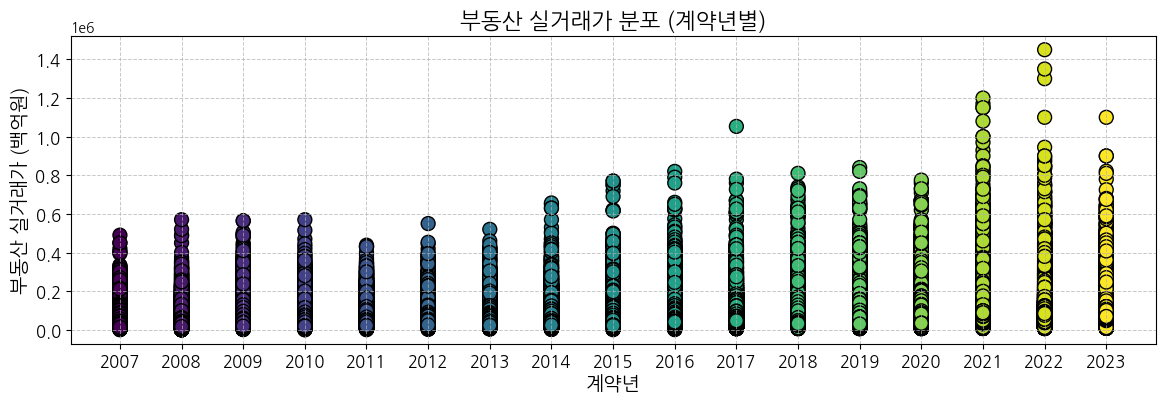

In [19]:
# 데이터 준비: '계약년'과 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['계약년', 'target']].dropna()

# 색상 맵 설정
cmap = plt.get_cmap('viridis')

# '계약년'의 범위를 0에서 1 사이로 정규화하여 색상에 매핑
norm = plt.Normalize(data['계약년'].min(), data['계약년'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.figure(figsize=(14, 4))
scatter = plt.scatter(data['계약년'], data['target'], c=data['계약년'], cmap=cmap, norm=norm, s=100, edgecolor='black')

# 제목 및 축 레이블 설정
plt.title('부동산 실거래가 분포 (계약년별)', fontsize=16, fontweight='bold')
plt.xlabel('계약년', fontsize=14)
plt.ylabel('부동산 실거래가 (백억원)', fontsize=14)

# x축 눈금 설정
years = sorted(data['계약년'].unique())
plt.xticks(ticks=years, labels=[str(year) for year in years], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

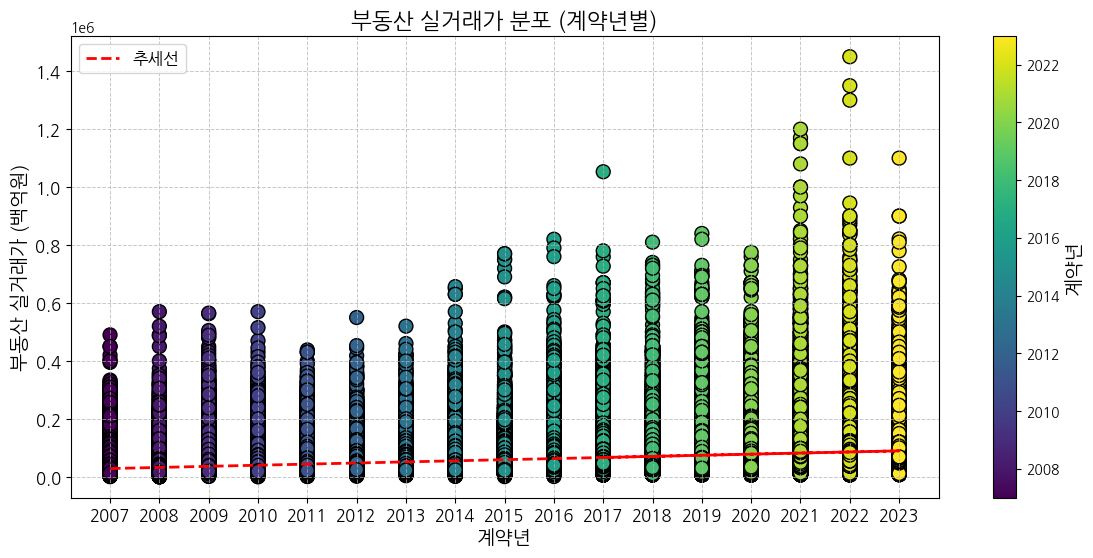

In [20]:
# 데이터 준비: '계약년'과 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['계약년', 'target']].dropna()

# 색상 맵 설정
cmap = plt.get_cmap('viridis')

# '계약년'의 범위를 0에서 1 사이로 정규화하여 색상에 매핑
norm = plt.Normalize(data['계약년'].min(), data['계약년'].max())

# 회귀 분석
coefficients = np.polyfit(data['계약년'], data['target'], 1)  # 1차 다항식(직선) 회귀
polynomial = np.poly1d(coefficients)
regression_line = polynomial(data['계약년'])

# 그래프 그리기
plt.figure(figsize=(14, 6))
scatter = plt.scatter(data['계약년'], data['target'], c=data['계약년'], cmap=cmap, norm=norm, s=100, edgecolor='black')

# 추세선 그리기
plt.plot(data['계약년'], regression_line, color='red', linewidth=2, linestyle='--', label='추세선')

# 컬러바 추가
cbar = plt.colorbar(scatter)
cbar.set_label('계약년', fontsize=14)

# 제목 및 축 레이블 설정
plt.title('부동산 실거래가 분포 (계약년별)', fontsize=16, fontweight='bold')
plt.xlabel('계약년', fontsize=14)
plt.ylabel('부동산 실거래가 (백억원)', fontsize=14)

# x축 눈금 설정
years = sorted(data['계약년'].unique())
plt.xticks(ticks=years, labels=[str(year) for year in years], fontsize=12)
plt.yticks(fontsize=12)

# 그리드 및 범례 설정
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend(fontsize=12)

# 차트 표시
plt.show()


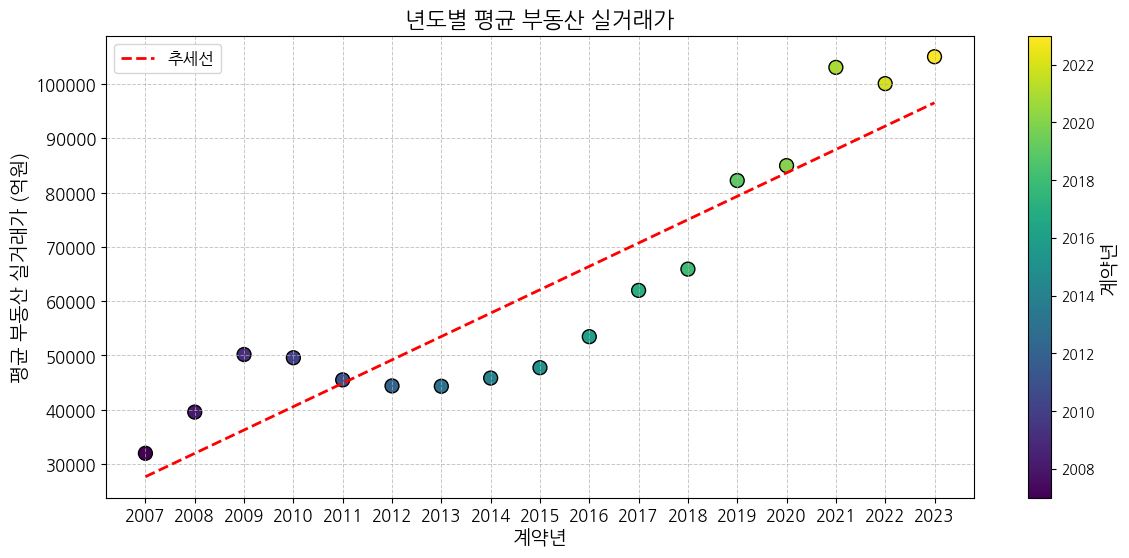

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# 데이터 준비: '계약년'과 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['계약년', 'target']].dropna()

# 년도별 평균 가격 계산
yearly_avg_price = data.groupby('계약년')['target'].mean().sort_index()

# 색상 맵 설정
cmap = plt.get_cmap('viridis')

# '계약년'의 범위를 0에서 1 사이로 정규화하여 색상에 매핑
norm = plt.Normalize(yearly_avg_price.index.min(), yearly_avg_price.index.max())

# 회귀 분석
coefficients = np.polyfit(yearly_avg_price.index, yearly_avg_price.values, 1)  # 1차 다항식(직선) 회귀
polynomial = np.poly1d(coefficients)
regression_line = polynomial(yearly_avg_price.index)

# 그래프 그리기
plt.figure(figsize=(14, 6))
scatter = plt.scatter(yearly_avg_price.index, yearly_avg_price.values, c=yearly_avg_price.index, cmap=cmap, norm=norm, s=100, edgecolor='black')

# 추세선 그리기
plt.plot(yearly_avg_price.index, regression_line, color='red', linewidth=2, linestyle='--', label='추세선')

# 컬러바 추가
cbar = plt.colorbar(scatter)
cbar.set_label('계약년', fontsize=14)

# 제목 및 축 레이블 설정
plt.title('년도별 평균 부동산 실거래가', fontsize=16, fontweight='bold')
plt.xlabel('계약년', fontsize=14)
plt.ylabel('평균 부동산 실거래가 (억원)', fontsize=14)

# x축 눈금 설정
years = sorted(yearly_avg_price.index)
plt.xticks(ticks=years, labels=[str(year) for year in years], fontsize=12)
plt.yticks(fontsize=12)

# 그리드 및 범례 설정
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend(fontsize=12)

# 차트 표시
plt.show()


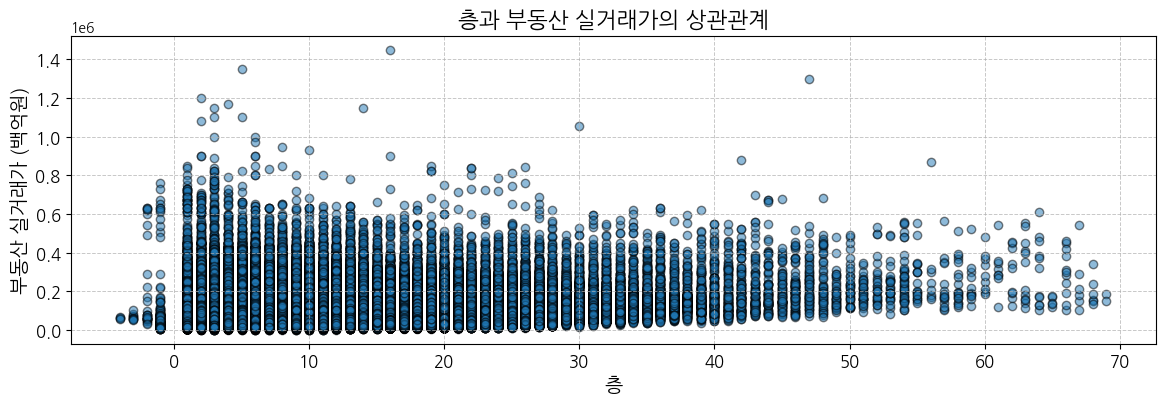

In [22]:
# 데이터 준비: '층'과 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['층', 'target']].dropna()

plt.figure(figsize=(14, 4))
plt.scatter(data['층'], data['target'], alpha=0.5, edgecolor='black')

# 제목 및 축 레이블 설정
plt.title('층과 부동산 실거래가의 상관관계', fontsize=16, fontweight='bold')
plt.xlabel('층', fontsize=14)
plt.ylabel('부동산 실거래가 (백억원)', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()


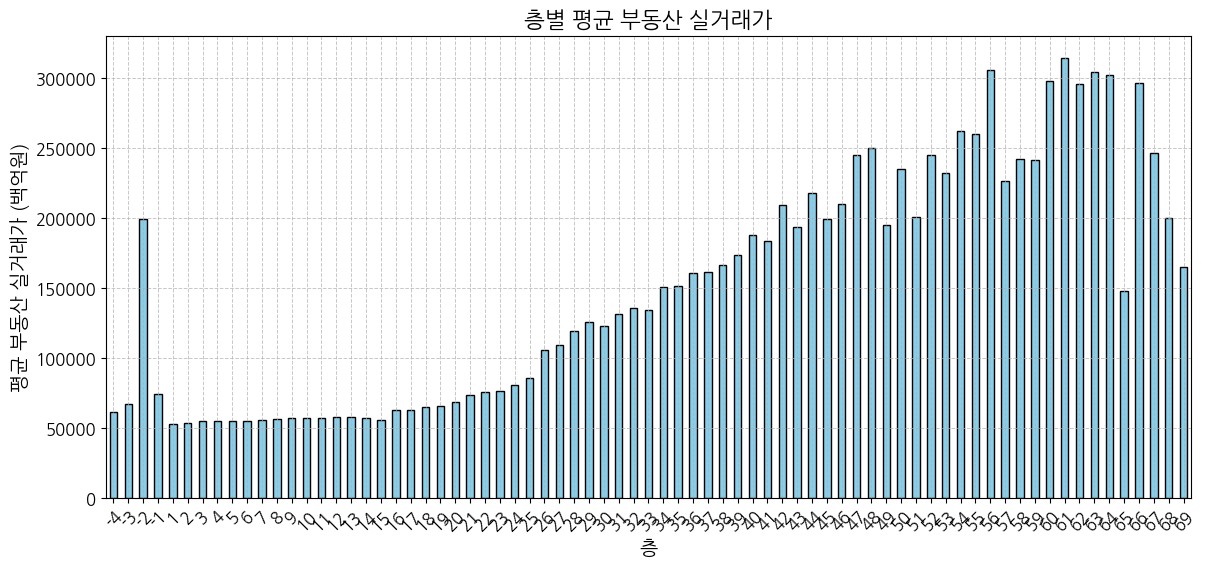

In [23]:
import matplotlib.pyplot as plt

# 데이터 준비: '층'과 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['층', 'target']].dropna()

# 층별 평균 거래가를 계산합니다.
mean_prices_per_floor = data.groupby('층')['target'].mean()

plt.figure(figsize=(14, 6))
mean_prices_per_floor.plot(kind='bar', color='skyblue', edgecolor='black')

# 제목 및 축 레이블 설정
plt.title('층별 평균 부동산 실거래가', fontsize=16, fontweight='bold')
plt.xlabel('층', fontsize=14)
plt.ylabel('평균 부동산 실거래가 (백억원)', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# 그리드 추가
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# 차트 표시
plt.show()


In [24]:
floor = 2
print(f'{floor}층 미만: ', train[(floor == train['층']) & (train['전용면적(㎡)'] > 10)]['target'].mean())
print(f'{floor}층 이상: ', train[(floor < train['층']) & (train['전용면적(㎡)'] > 10)]['target'].mean())

2층 미만:  53645.097589469995
2층 이상:  58679.398935340454


In [25]:
floor_diff_value_list = dict()
for floor in range(1, 100, 1):
    diff = train[((floor+1) == train['층']) & (train['전용면적(㎡)'] > 10)]['target'].mean() - train[(floor == train['층']) & (train['전용면적(㎡)'] > 10)]['target'].mean()
    if np.isnan(diff):
        break
    floor_diff_value_list[floor] = int(diff)

print(floor_diff_value_list)

{1: 769, 2: 1413, 3: -358, 4: 589, 5: -446, 6: 502, 7: 866, 8: 931, 9: 58, 10: 258, 11: 296, 12: -170, 13: -460, 14: -1223, 15: 7164, 16: -169, 17: 1742, 18: 1171, 19: 2419, 20: 5135, 21: 2231, 22: 1029, 23: 4264, 24: 5110, 25: 19354, 26: 3577, 27: 10545, 28: 6295, 29: -2880, 30: 8414, 31: 4131, 32: -1443, 33: 16650, 34: 527, 35: 9371, 36: 597, 37: 4955, 38: 7222, 39: 14409, 40: -4423, 41: 26081, 42: -15990, 43: 24077, 44: -18092, 45: 10715, 46: 35104, 47: 4414, 48: -54621, 49: 40098, 50: -34468, 51: 44140, 52: -12884, 53: 30348, 54: -2166, 55: 45433, 56: -79092, 57: 15381, 58: -607, 59: 56540, 60: 16402, 61: -18513, 62: 8638, 63: -2159, 64: -154430, 65: 148521, 66: -50098, 67: -45875, 68: -35208}


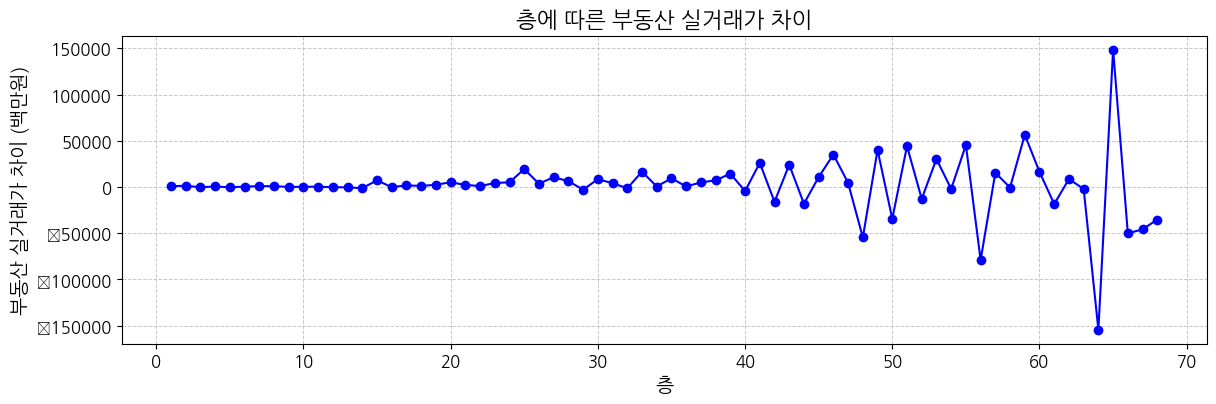

In [26]:
plt.figure(figsize=(14, 4))
plt.plot(floor_diff_value_list.keys(), floor_diff_value_list.values(), marker='o', linestyle='-', color='b')

# 제목 및 축 레이블 설정
plt.title('층에 따른 부동산 실거래가 차이', fontsize=16, fontweight='bold')
plt.xlabel('층', fontsize=14)
plt.ylabel('부동산 실거래가 차이 (백만원)', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 그리드 추가
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# 차트 표시
plt.show()

In [27]:
floor_diff_value_list = dict()
for floor in range(2, 100, 1):
    diff = train[(floor < train['층']) & (train['전용면적(㎡)'] > 10)]['target'].mean() - train[(floor >= train['층']) & (train['전용면적(㎡)'] > 10)]['target'].mean()
    if np.isnan(diff):
        break
    floor_diff_value_list[floor] = int(diff)

print(floor_diff_value_list)

{2: 5328, 3: 5043, 4: 5280, 5: 5509, 6: 6007, 7: 6507, 8: 6950, 9: 7365, 10: 7997, 11: 8842, 12: 9992, 13: 11608, 14: 14087, 15: 18241, 16: 20236, 17: 23095, 18: 26616, 19: 31024, 20: 36339, 21: 41136, 22: 47311, 23: 55389, 24: 64839, 25: 75622, 26: 81332, 27: 87989, 28: 93401, 29: 98240, 30: 104461, 31: 109654, 32: 115417, 33: 122489, 34: 128141, 35: 135103, 36: 141531, 37: 147241, 38: 152995, 39: 158903, 40: 162616, 41: 167528, 42: 169708, 43: 174406, 44: 176325, 45: 181102, 46: 186487, 47: 186345, 48: 185539, 49: 191283, 50: 193005, 51: 200248, 52: 201853, 53: 205649, 54: 206006, 55: 206564, 56: 203919, 57: 208799, 58: 214070, 59: 218366, 60: 215615, 61: 210383, 62: 205755, 63: 193894, 64: 175481, 65: 192642, 66: 156849, 67: 133415, 68: 107008}


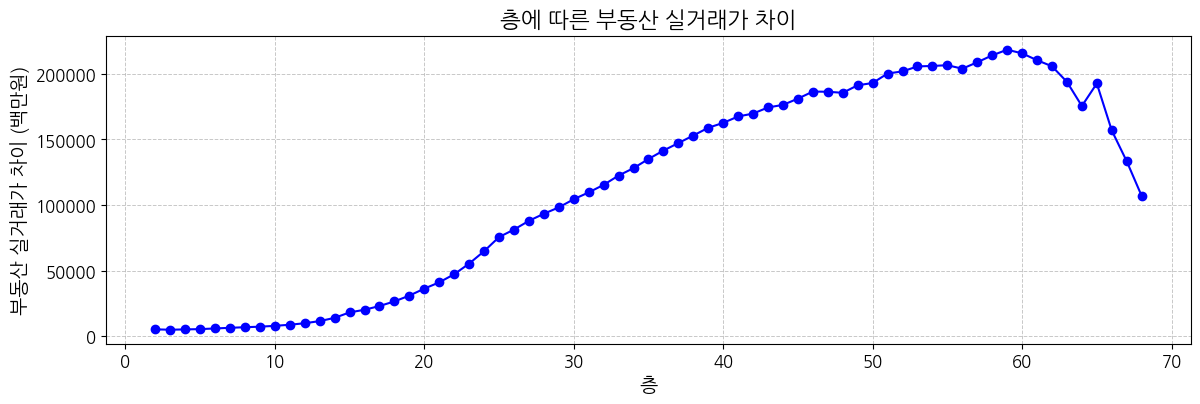

In [28]:
plt.figure(figsize=(14, 4))
plt.plot(floor_diff_value_list.keys(), floor_diff_value_list.values(), marker='o', linestyle='-', color='b')

# 제목 및 축 레이블 설정
plt.title('층에 따른 부동산 실거래가 차이', fontsize=16, fontweight='bold')
plt.xlabel('층', fontsize=14)
plt.ylabel('부동산 실거래가 차이 (백만원)', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 그리드 추가
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# 차트 표시
plt.show()

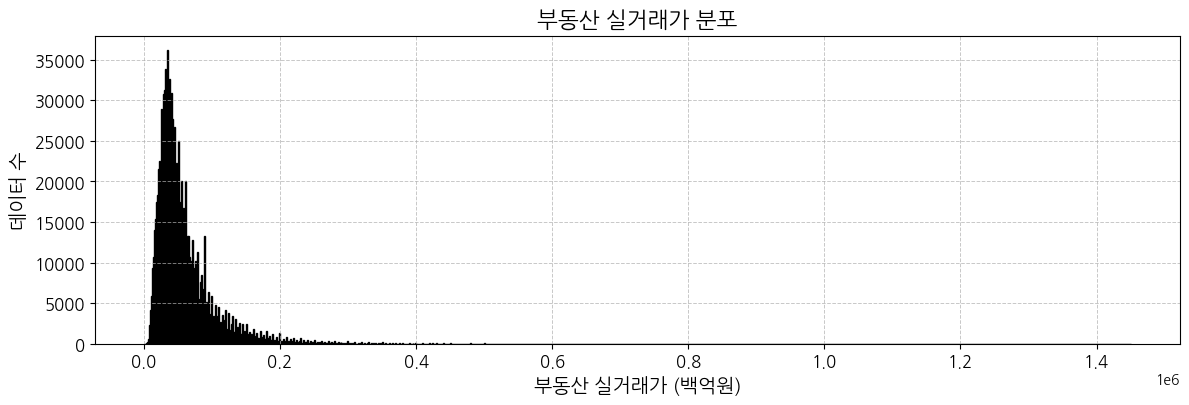

In [29]:
# 데이터 준비: 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['target']].dropna()

# 히스토그램을 생성합니다.
plt.figure(figsize=(14, 4))
plt.hist(data['target'], bins=1000, edgecolor='black')

# 제목 및 축 레이블 설정
plt.title('부동산 실거래가 분포', fontsize=16, fontweight='bold')
plt.xlabel('부동산 실거래가 (백억원)', fontsize=14)
plt.ylabel('데이터 수', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 그리드 추가
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# 차트 표시
plt.show()

###  == 위 차트 분석 결과 ==

- 양의 왜도(Right skewed) 형태이다.
- 0 ~ 10억 사이의 데이터가 가장 많다.
- 20억 이상하는 부동산은 데이터 양이 적으니, 예측이 어려울 것이다.

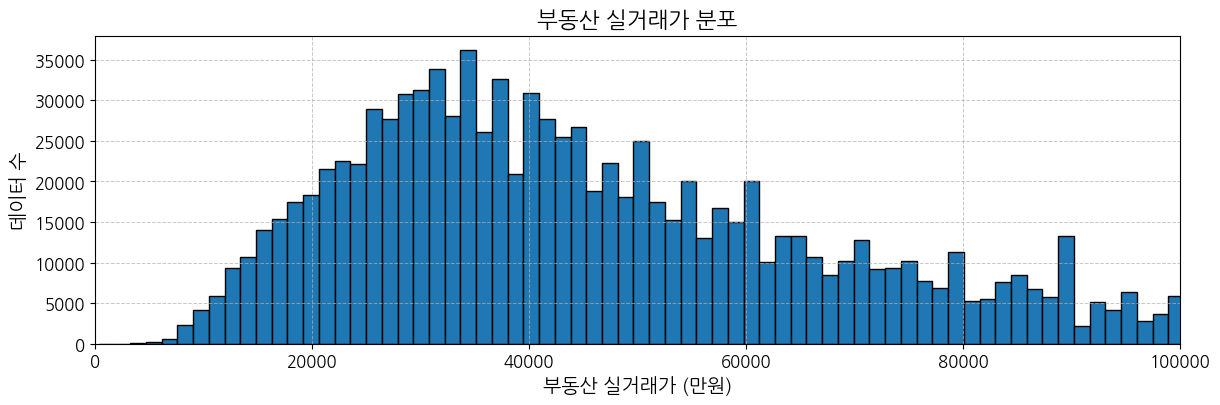

In [30]:
# 데이터 준비: 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['target']].dropna()

# 히스토그램을 생성합니다.
plt.figure(figsize=(14, 4))
plt.hist(data['target'], bins=1000, edgecolor='black')

# 제목 및 축 레이블 설정
plt.title('부동산 실거래가 분포', fontsize=16, fontweight='bold')
plt.xlabel('부동산 실거래가 (만원)', fontsize=14)
plt.ylabel('데이터 수', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, 100000)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

### == 위 차트 분석 결과 ==

- 앞서 살펴보았던 차트에서, 가장 데이터가 많았던 부분만 확대한 차트이다.
- 3억 ~ 4억 부근의 데이터가 가장 많다.

In [31]:
print('target의 max: ', train['target'].max())
print('target의 min: ', train['target'].min())

target의 max:  1450000
target의 min:  350


In [32]:
print(train[train['target'] < 1000])

                     시군구      번지      본번    부번   아파트명  전용면적(㎡)    계약년월  계약일  \
197746     서울특별시 은평구 구산동  199-24   199.0  24.0     신호   88.930  200812    1   
197747     서울특별시 은평구 구산동  199-24   199.0  24.0     신호   83.700  200812    1   
197748     서울특별시 은평구 구산동  199-24   199.0  24.0     신호   83.700  200812    1   
197749     서울특별시 은평구 구산동  199-24   199.0  24.0     신호  100.530  200812    1   
197750     서울특별시 은평구 구산동  199-24   199.0  24.0     신호  100.530  200812    1   
197751     서울특별시 은평구 구산동  199-24   199.0  24.0     신호   83.700  200812    1   
197752     서울특별시 은평구 구산동  199-24   199.0  24.0     신호  100.530  200812    1   
197753     서울특별시 은평구 구산동  199-24   199.0  24.0     신호  100.530  200812    1   
197754     서울특별시 은평구 구산동  199-24   199.0  24.0     신호  100.530  200812    1   
197755     서울특별시 은평구 구산동  199-24   199.0  24.0     신호   83.700  200812    1   
197756     서울특별시 은평구 구산동  199-24   199.0  24.0     신호  100.530  200812    1   
197757     서울특별시 은평구 구산동  199-24   199.0  24.0     신

In [33]:
print('계약년월의 max: ', train['계약년월'].max())
print('계약년월의 min: ', train['계약년월'].min())

계약년월의 max:  202306
계약년월의 min:  200701


In [34]:
print('아파트 종류: ', len(train['아파트명'].unique()))
display(train['아파트명'].value_counts()[:10])

아파트 종류:  6539


현대       16644
신동아      12846
한신        9074
두산        8533
주공2       7918
우성        7768
벽산        7285
삼성래미안     7143
대림        6305
극동        5669
Name: 아파트명, dtype: int64

In [35]:
train['구'].value_counts()[:10]

노원구    115099
송파구     73785
강남구     69083
강서구     66610
강동구     61895
구로구     57604
성북구     56675
양천구     53977
서초구     53126
도봉구     52572
Name: 구, dtype: int64

In [36]:
train['동'].value_counts()[:10]

상계동    44948
중계동    26357
신정동    24038
창동     23101
구로동    22811
봉천동    20511
목동     17246
월계동    17056
서초동    15899
공릉동    15763
Name: 동, dtype: int64

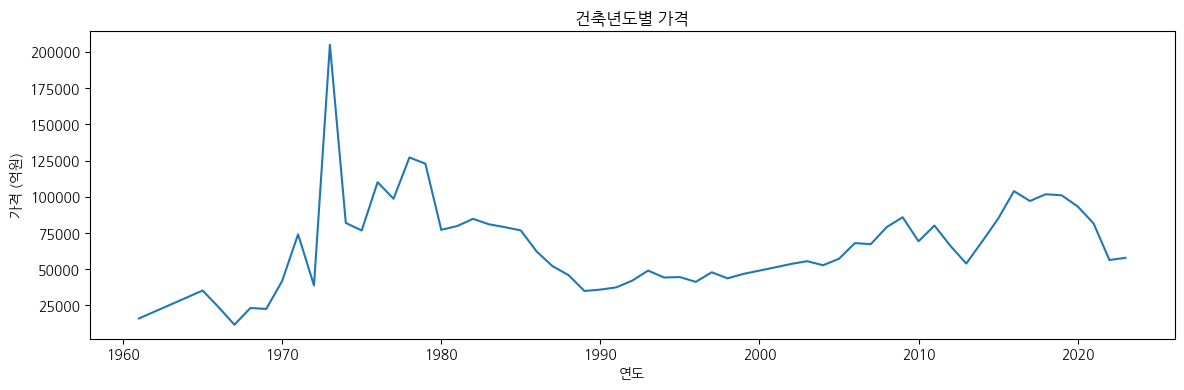

In [37]:
train_yearly = train.groupby(train['건축년도'])['target'].mean()

plt.figure(figsize=(14, 4))
plt.plot(train_yearly.index, train_yearly.values)
plt.xlabel('연도')
plt.ylabel('가격 (억원)')
plt.title('건축년도별 가격')
plt.show()

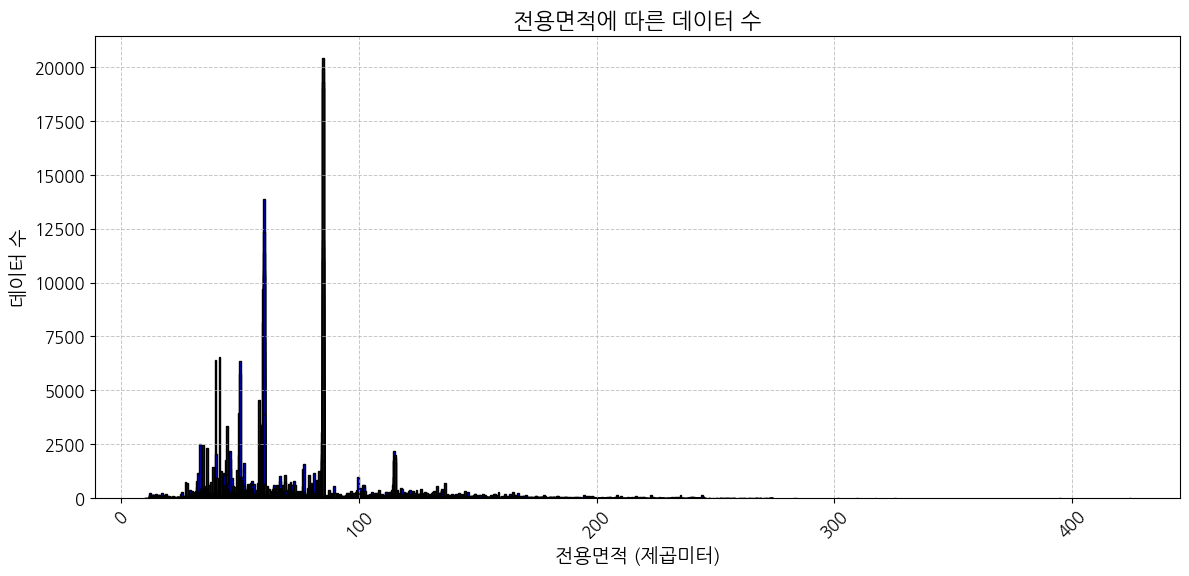

In [38]:
# 데이터 준비: 'area'와 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['전용면적(㎡)']].dropna()

# 전용면적별 데이터 수를 계산합니다.
area_counts = data['전용면적(㎡)'].value_counts().sort_index()

# 라인 차트를 그립니다.
plt.figure(figsize=(14, 6))
plt.bar(area_counts.index, area_counts.values, color='b', edgecolor='black')

# 제목 및 축 레이블 설정
plt.title('전용면적에 따른 데이터 수', fontsize=16, fontweight='bold')
plt.xlabel('전용면적 (제곱미터)', fontsize=14)
plt.ylabel('데이터 수', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12, rotation=45)  # x축 레이블을 더 잘 보이도록 회전
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

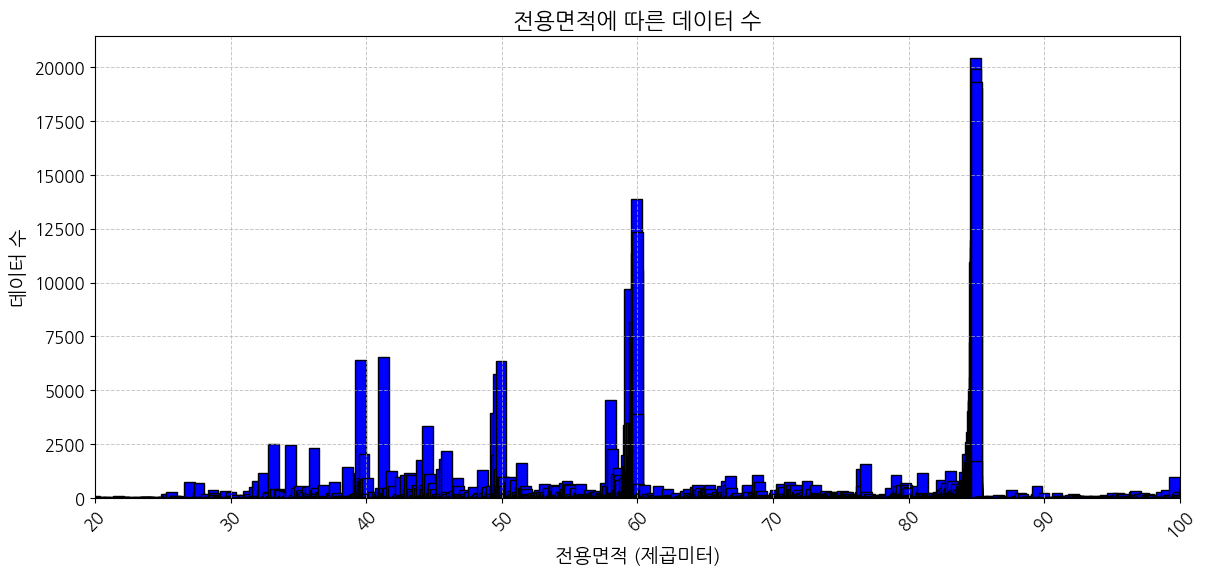

In [39]:
# 데이터 준비: 'area'와 'target'을 포함한 데이터 프레임을 생성합니다.
data = train[['전용면적(㎡)']].dropna()

# 전용면적별 데이터 수를 계산합니다.
area_counts = data['전용면적(㎡)'].value_counts().sort_index()

# 라인 차트를 그립니다.
plt.figure(figsize=(14, 6))
plt.bar(area_counts.index, area_counts.values, color='b', edgecolor='black')

# 제목 및 축 레이블 설정
plt.title('전용면적에 따른 데이터 수', fontsize=16, fontweight='bold')
plt.xlabel('전용면적 (제곱미터)', fontsize=14)
plt.ylabel('데이터 수', fontsize=14)

# x축과 y축 레이블의 폰트 크기 설정
plt.xticks(fontsize=12, rotation=45)  # x축 레이블을 더 잘 보이도록 회전
plt.yticks(fontsize=12)
plt.xlim(20, 100)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
plt.show()

In [40]:
train['세대별주차대수'] = train['주차대수'] / train['k-전체세대수']
test['세대별주차대수'] = test['주차대수'] / test['k-전체세대수']

In [41]:
# '동+아파트명' 기준으로 그룹화하여 'target' 피처의 평균 가격 계산
mean_target_per_group = train.groupby('동+아파트명')['target'].mean()

# 평균 가격이 200,000 이상인 그룹을 리스트로 생성
high_price_groups = mean_target_per_group[mean_target_per_group >= 200000].index.tolist()

# train 데이터에 'top_apt' 피처 추가
train['top_apt'] = train['동+아파트명'].apply(lambda x: 1 if x in high_price_groups else 0).astype('category')

# test 데이터에 'top_apt' 피처 추가
test['top_apt'] = test['동+아파트명'].apply(lambda x: 1 if x in high_price_groups else 0).astype('category')

In [42]:
train['국민평수'] = train['전용면적(㎡)'].apply(lambda x: 1 if x <= 90 else 0)

In [43]:
# from scipy.spatial import cKDTree

# def haversine_distance(lat1, lon1, lat2, lon2):
#     R = 6371  # 지구의 반경 (km)
#     lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
#     dlat = lat2 - lat1
#     dlon = lon2 - lon1
#     a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
#     c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
#     distance = R * c
#     return distance * 1000  # 미터 단위로 변환

# def walking_time(distance):
#     return distance / (4000/60)  # 4km/h의 걷는 속도 가정

# def add_subway_features(apartment_df, subway_df):
#     apartment_coords = apartment_df[['좌표Y', '좌표X']].values
#     station_coords = subway_df[['위도', '경도']].values

#     # 가장 가까운 3개의 역 찾기
#     tree = cKDTree(station_coords)
#     distances, indices = tree.query(apartment_coords, k=3)

#     for i in range(1):
#         apartment_df[f'{i+1}번째_가까운_역_이름'] = subway_df.loc[indices[:, i], '역사명'].values
#         apartment_df[f'{i+1}번째_가까운_역_호선'] = subway_df.loc[indices[:, i], '호선'].values
#         apartment_df[f'{i+1}번째_가까운_역_거리'] = np.array([haversine_distance(ac[0], ac[1], station_coords[idx][0], station_coords[idx][1]) 
#                                                    for ac, idx in zip(apartment_coords, indices[:, i])])
#         # apartment_df[f'{i+1}번째_가까운_역_도보시간'] = walking_time(apartment_df[f'{i+1}번째_가까운_역_거리'])

#     # 시간대별 역 개수 계산
#     def count_stations_in_time_range(min_time, max_time):
#         min_dist = min_time * (4000/60)
#         max_dist = max_time * (4000/60)
#         return np.array([np.sum((min_dist < haversine_distance(c[0], c[1], station_coords[:, 0], station_coords[:, 1])) & 
#                                 (haversine_distance(c[0], c[1], station_coords[:, 0], station_coords[:, 1]) <= max_dist)) 
#                          for c in apartment_coords])

#     apartment_df['5분이하_역_개수'] = count_stations_in_time_range(0, 5)
#     apartment_df['5분초과_10분이하_역_개수'] = count_stations_in_time_range(5, 10)
#     # apartment_df['10분초과_15분이하_역_개수'] = count_stations_in_time_range(10, 15)
#     # apartment_df['15분초과_20분이하_역_개수'] = count_stations_in_time_range(15, 20)

#     return apartment_df

# train = add_subway_features(train, subway)
# train['1번째_가까운_역_이름'] = train['1번째_가까운_역_이름'].astype('category')
# train['1번째_가까운_역_호선'] = train['1번째_가까운_역_호선'].astype('category')
# train['1번째_가까운_역_이름'] = train['1번째_가까운_역_이름'].astype('category')

In [44]:
# test = add_subway_features(test, subway)
# test['1번째_가까운_역_이름'] = test['1번째_가까운_역_이름'].astype('category')
# test['1번째_가까운_역_호선'] = test['1번째_가까운_역_호선'].astype('category')
# test['1번째_가까운_역_이름'] = test['1번째_가까운_역_이름'].astype('category')

In [45]:
selected_feature_list = ['아파트명', '전용면적(㎡)', '계약년월', '층', '건축년도', '구', '동', '도로명', '세대별주차대수', '좌표X', '좌표Y', 'target', '서울시_가계대출', 'top_apt', '국민평수', '1번째_가까운_역_이름', '1번째_가까운_역_호선', '1번째_가까운_역_거리', '5분이하_역_개수', '5분초과_10분이하_역_개수']
train = train[selected_feature_list]

In [46]:
print((train.isnull().mean() * 100).to_string())

아파트명                0.190021
전용면적(㎡)             0.000000
계약년월                0.000000
층                   0.000000
건축년도                0.000000
구                   0.000000
동                   0.000000
도로명                 0.000000
세대별주차대수            22.778333
좌표X                 0.000000
좌표Y                 0.000000
target              0.000000
서울시_가계대출            5.252578
top_apt             0.000000
국민평수                0.000000
1번째_가까운_역_이름        0.000000
1번째_가까운_역_호선        0.000000
1번째_가까운_역_거리        0.000000
5분이하_역_개수           0.000000
5분초과_10분이하_역_개수     0.000000


In [47]:
def impute_missing_values(df):
    # 수치형 피처와 범주형 피처 구분
    numeric_features = df.select_dtypes(include=[np.number]).columns
    categorical_features = df.select_dtypes(include=[object]).columns
    
    # 수치형 피처의 결측치를 평균값으로 대체
    # for feature in numeric_features:
    #     mean_value = df[feature].mean()
    #     df[feature].fillna(mean_value, inplace=True)
    
    # 수치형 피처의 결측치를 -999으로 대체
    for feature in numeric_features:
        df[feature].fillna(-999, inplace=True)
    
    # 범주형 피처의 결측치를 'Missing'으로 대체
    for feature in categorical_features:
        df[feature].fillna('Missing', inplace=True)
    
    return df

impute_missing_values(train)

,아파트명,전용면적(㎡),계약년월,층,건축년도,구,동,도로명,세대별주차대수,좌표X,좌표Y,target,서울시_가계대출,top_apt,국민평수,1번째_가까운_역_이름,1번째_가까운_역_호선,1번째_가까운_역_거리,5분이하_역_개수,5분초과_10분이하_역_개수
0,개포6차우성,79.97,201712,3,1987,강남구,개포동,언주로 3,0.970370,127.056859,37.476276,124000,282438.7,0,1,구룡,분당선,1187.672025,0,0
1,개포6차우성,79.97,201712,4,1987,강남구,개포동,언주로 3,0.970370,127.056859,37.476276,123500,282438.7,0,1,구룡,분당선,1187.672025,0,0
2,개포6차우성,54.98,201712,5,1987,강남구,개포동,언주로 3,0.970370,127.056859,37.476276,91500,282438.7,0,1,구룡,분당선,1187.672025,0,0
3,개포6차우성,79.97,201801,4,1987,강남구,개포동,언주로 3,0.970370,127.056859,37.476276,130000,283669.8,0,1,구룡,분당선,1187.672025,0,0
4,개포6차우성,79.97,201801,2,1987,강남구,개포동,언주로 3,0.970370,127.056859,37.476276,117000,283669.8,0,1,구룡,분당선,1187.672025,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,갈현현대,59.94,200707,11,1998,은평구,구산동,서오릉로21길 36,1.000000,126.905543,37.612989,20000,-999.0,0,1,구산,6호선,1048.367837,0,0
1118818,갈현현대,59.94,200708,10,1998,은평구,구산동,서오릉로21길 36,1.000000,126.905543,37.612989,20000,-999.0,0,1,구산,6호선,1048.367837,0,0
1118819,갈현현대,84.83,200708,20,1998,은평구,구산동,서오릉로21길 36,1.000000,126.905543,37.612989,28000,-999.0,0,1,구산,6호선,1048.367837,0,0
1118820,갈현현대,84.83,200709,8,1998,은평구,구산동,서오릉로21길 36,1.000000,126.905543,37.612989,29000,-999.0,0,1,구산,6호선,1048.367837,0,0


In [48]:
print((train.isnull().mean() * 100).to_string())

아파트명               0.0
전용면적(㎡)            0.0
계약년월               0.0
층                  0.0
건축년도               0.0
구                  0.0
동                  0.0
도로명                0.0
세대별주차대수            0.0
좌표X                0.0
좌표Y                0.0
target             0.0
서울시_가계대출           0.0
top_apt            0.0
국민평수               0.0
1번째_가까운_역_이름       0.0
1번째_가까운_역_호선       0.0
1번째_가까운_역_거리       0.0
5분이하_역_개수          0.0
5분초과_10분이하_역_개수    0.0


In [49]:
train = train[~train['층'].isin([-2, 65])]

In [50]:
train = train[train['계약년월'] >= 201801]

In [51]:
SEED = 1053682552

# TARGET 정의
TARGET = 'target'

# NUMERIC_COLS 계산: TARGET을 제외한 수치형 컬럼 리스트
NUMERIC_COLS = [col for col in train.select_dtypes(include=[float, int]).columns if col != TARGET]

# CAT_COLS 계산: NUMERIC_COLS를 제외한 나머지 컬럼 리스트
CAT_COLS = [col for col in train.columns if col not in NUMERIC_COLS + [TARGET]]

print(f'Target         --> {TARGET}')
print(f'Numeric Cols   --> {NUMERIC_COLS}')
print(f'Categoric Cols --> {CAT_COLS}')

Target         --> target
Numeric Cols   --> ['전용면적(㎡)', '계약년월', '층', '건축년도', '세대별주차대수', '좌표X', '좌표Y', '서울시_가계대출', '국민평수', '1번째_가까운_역_거리', '5분이하_역_개수', '5분초과_10분이하_역_개수']
Categoric Cols --> ['아파트명', '구', '동', '도로명', 'top_apt', '1번째_가까운_역_이름', '1번째_가까운_역_호선']


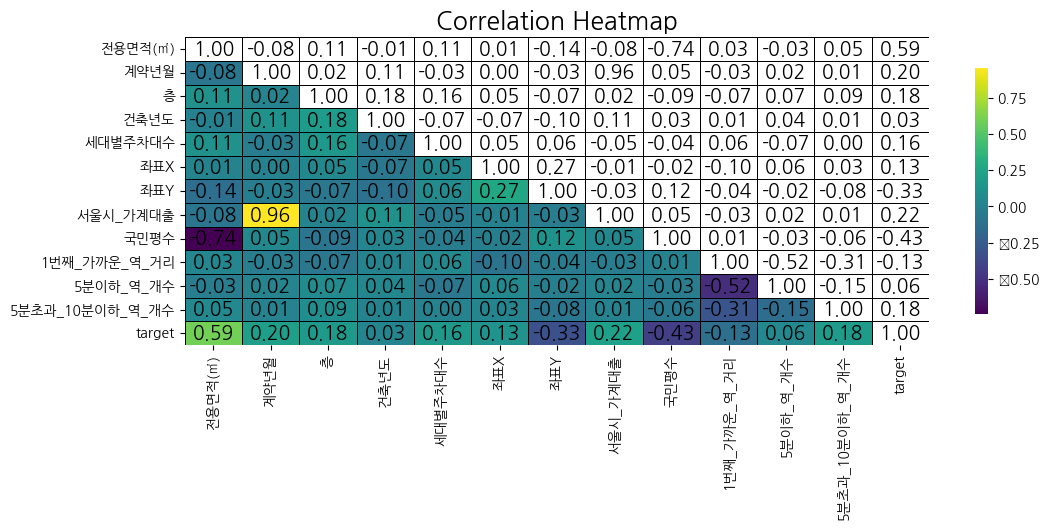

In [52]:
# 상관 행렬 계산
corr = train[NUMERIC_COLS + [TARGET]].corr()

# 마스크 생성
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵 그리기
plt.figure(figsize=(12, 4))  # 그래프 크기 조정
ax = sns.heatmap(corr, mask=mask, cmap='viridis', linewidths=0.5, linecolor='black', cbar_kws={"shrink": .8})

# 각 셀에 숫자 추가
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        text = f"{corr.iloc[i, j]:.2f}"
        ax.text(j + 0.5, i + 0.5, text,
                ha='center', va='center',
                color='black',  # 글자색 검은색
                fontsize=14,    # 글자 크기 조정
                fontweight='bold')  # 글자 굵게

# 타이틀 추가
plt.title('Correlation Heatmap', size=18)

# 그래프 표시
plt.show()

In [53]:
selected_feature_list = ['아파트명', '전용면적(㎡)', '계약년월', '층', '건축년도', '구', '동', '도로명', '세대별주차대수', '좌표X', '좌표Y', 'target', 'top_apt', '국민평수', '1번째_가까운_역_이름', '1번째_가까운_역_호선', '1번째_가까운_역_거리', '5분이하_역_개수', '5분초과_10분이하_역_개수']
train = train[selected_feature_list]

SEED = 1053682552

# TARGET 정의
TARGET = 'target'

# NUMERIC_COLS 계산: TARGET을 제외한 수치형 컬럼 리스트
NUMERIC_COLS = [col for col in train.select_dtypes(include=[float, int]).columns if col != TARGET]

# CAT_COLS 계산: NUMERIC_COLS를 제외한 나머지 컬럼 리스트
CAT_COLS = [col for col in train.columns if col not in NUMERIC_COLS + [TARGET]]

print(f'Target         --> {TARGET}')
print(f'Numeric Cols   --> {NUMERIC_COLS}')
print(f'Categoric Cols --> {CAT_COLS}')

Target         --> target
Numeric Cols   --> ['전용면적(㎡)', '계약년월', '층', '건축년도', '세대별주차대수', '좌표X', '좌표Y', '국민평수', '1번째_가까운_역_거리', '5분이하_역_개수', '5분초과_10분이하_역_개수']
Categoric Cols --> ['아파트명', '구', '동', '도로명', 'top_apt', '1번째_가까운_역_이름', '1번째_가까운_역_호선']


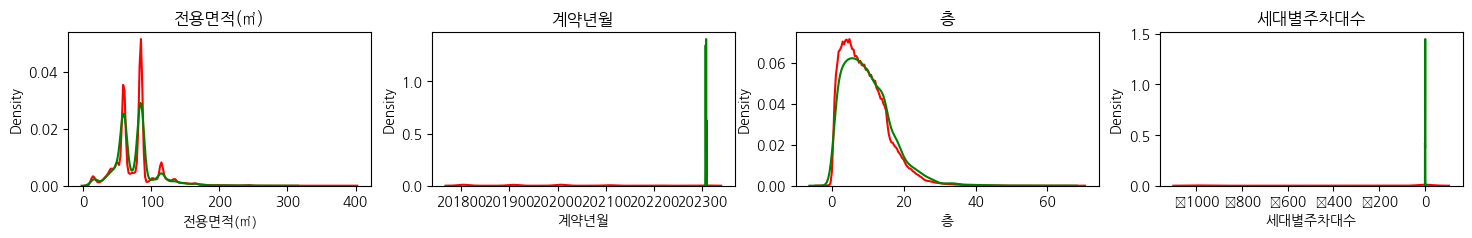

In [54]:
col_list = ['전용면적(㎡)', '계약년월', '층', '세대별주차대수']

n_cols = len(col_list)
n_rows = math.ceil(len(col_list)/n_cols)
fig, ax = plt.subplots(1,n_cols, figsize=(18, 2))
ax = ax.flatten()
plt.subplots_adjust(wspace=0.2)
for i,c in enumerate(col_list):
    sns.kdeplot(train[c],color='red',ax=ax[i])
    sns.kdeplot(test[c],color='green',ax=ax[i])
    ax[i].set_title(f'{c}')
for j in range(len(col_list),len(ax)):
    ax[j].axis('off')
plt.show()
    

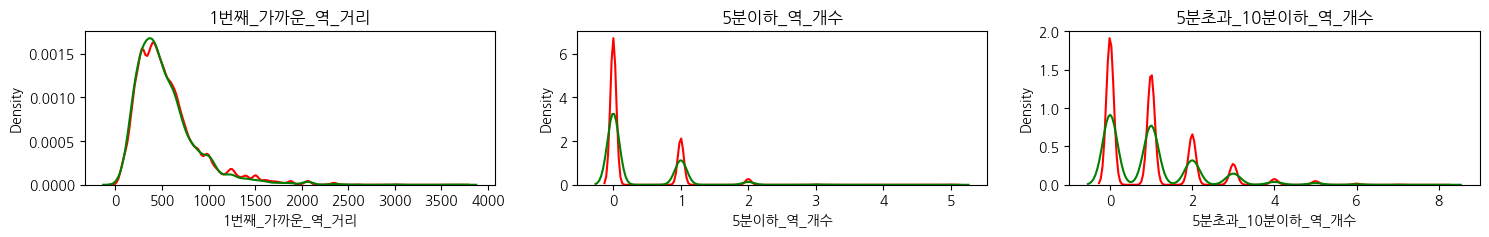

In [55]:
col_list = ['1번째_가까운_역_거리', '5분이하_역_개수', '5분초과_10분이하_역_개수']

n_cols = len(col_list)
n_rows = math.ceil(len(col_list)/n_cols)
fig, ax = plt.subplots(1,n_cols, figsize=(18, 2))
ax = ax.flatten()
plt.subplots_adjust(wspace=0.2)
for i,c in enumerate(col_list):
    sns.kdeplot(train[c],color='red',ax=ax[i])
    sns.kdeplot(test[c],color='green',ax=ax[i])
    ax[i].set_title(f'{c}')
for j in range(len(col_list),len(ax)):
    ax[j].axis('off')
plt.show()
    

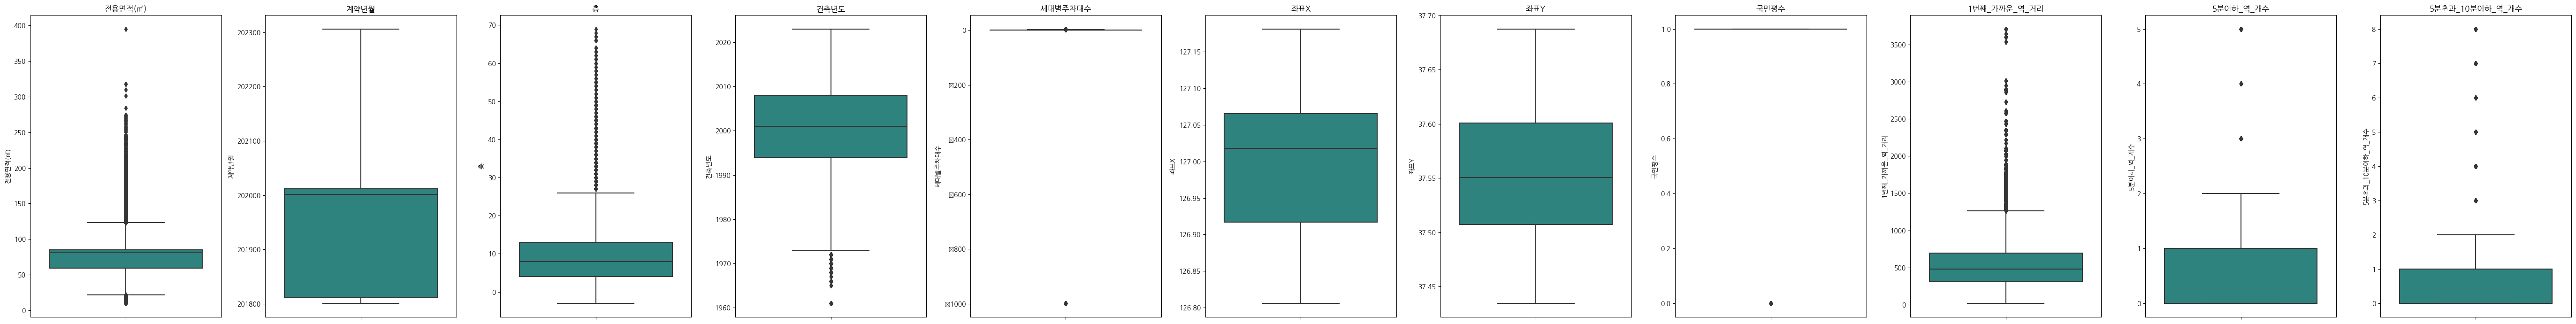

In [56]:
# 수치형 피처들에 대한 박스 플롯 그리기
fig, axes = plt.subplots(nrows=1, ncols=len(NUMERIC_COLS), figsize=(len(NUMERIC_COLS) * 5, 7))

# 각 수치형 피처에 대해 박스 플롯을 그립니다.
for ax, column in zip(axes, NUMERIC_COLS):
    sns.boxplot(data=train, y=column, ax=ax, palette="viridis")
    ax.set_title(f'{column}')

plt.tight_layout()
plt.show()